<a href="https://colab.research.google.com/github/garrisongys/BNN/blob/master/BNN_larq_CIFIAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source from https://docs.larq.dev/larq/tutorials/binarynet_cifar10/

In [1]:
!pip install larq

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c7ffbbd8f62b6072529327cd7e3246d7a6494a2762de0ab59c0fb0cf4e8a257d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [0]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3)).astype("float32")
test_images = test_images.reshape((10000, 32, 32, 3)).astype("float32")

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [5]:
lq.models.summary(model)

+sequential stats---------------------------------------------------------------------------------------------+
| Layer                  Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                          x 1       x 1     (kB)                          |
+-------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 30, 30, 128)      3456         0     0.42           0      3110400 |
| batch_normalization              -  (-1, 30, 30, 128)         0       256     1.00           0            0 |
| quant_conv2d_1                   1  (-1, 30, 30, 128)    147456         0    18.00   132710400            0 |
| max_pooling2d                    -  (-1, 15, 15, 128)         0         0        0           0            0 |
| batch_normalization_1            -  (-1, 15, 15, 128)         0       256     1.00           0        

In [0]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01,decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [11]:
trained_model = model.fit(
    train_images, 
    train_labels,
    batch_size=50, 
    epochs=100,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Epoch 1/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3710 - accuracy: 0.9951 - val_loss: 0.8050 - val_accuracy: 0.8274
Epoch 2/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3708 - accuracy: 0.9947 - val_loss: 0.8344 - val_accuracy: 0.8217
Epoch 3/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3722 - accuracy: 0.9949 - val_loss: 0.8107 - val_accuracy: 0.8281
Epoch 4/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3689 - accuracy: 0.9955 - val_loss: 0.8329 - val_accuracy: 0.8214
Epoch 5/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3677 - accuracy: 0.9955 - val_loss: 0.8341 - val_accuracy: 0.8201
Epoch 6/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3679 - accuracy: 0.9953 - val_loss: 0.8492 - val_accuracy: 0.8234
Epoch 7/100
1000/1000 [==============================] - 22s 22ms/step - loss: 0.3648 - accuracy: 0.9964 - val_loss: 0

0.9978799819946289
0.8422999978065491


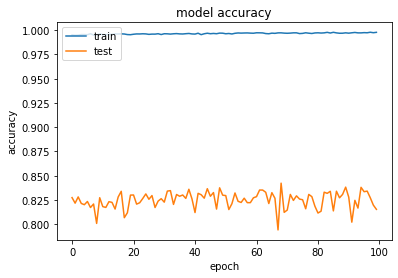

In [16]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

# New Section

0.3566998541355133
0.757627546787262


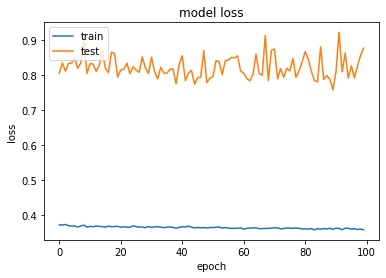

In [15]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))